In [150]:
import re
import math
import nltk
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from nltk.tokenize import sent_tokenize

In [151]:
def n_grams(lst, n):
    count = {}
    total_count = 0
    for i, item in enumerate(lst):
        x = item.split()
        for j in range(len(x)-n+1):
            y = []
            for k in range(n):
                y.append(x[j+k])
                s = " ".join(y)
            count[s] = count.get(s, 0) + 1
            total_count += 1
    return count, total_count


def MLE_calculation(n_grams, n_1_grams):
    MLE = {}
    for i in n_grams.keys():
        lst = i.split()
        MLE[i] = n_grams[i]/n_1_grams[' '.join(lst[:len(lst)-1])]
    return MLE

In [152]:
file = open("sherlock.txt", 'r', encoding="utf8")
sentence_list = sent_tokenize(file.read())
file.close()

special_chars = re.compile('[`~!@#$%^&*()+={}|\[\]:";<>?,\./“”]')

for i, item in enumerate(sentence_list):
    text = item.replace("\n", " ")
    text = "<s> " + special_chars.sub("", text) + " </s>"
    text = text.lower()
    sentence_list[i] = ' '.join(text.split())

test = sentence_list[int(len(sentence_list)*0.8):]
sentence_list = sentence_list[:int(len(sentence_list)*0.8)]

In [153]:
unigrams, total_unigrams = n_grams(sentence_list, 1)
bigrams, total_bigrams = n_grams(sentence_list, 2)
trigrams, total_trigrams = n_grams(sentence_list, 3)
quadgrams, total_quadgrams = n_grams(sentence_list, 4)

In [154]:
MLE_unigrams = {}
for i in unigrams.keys():
    MLE_unigrams[i] = unigrams[i]/total_unigrams
    
MLE_bigrams = MLE_calculation(bigrams, unigrams)
MLE_trigrams = MLE_calculation(trigrams, bigrams)
MLE_quadgrams = MLE_calculation(quadgrams, trigrams)

In [155]:
def conversion(n_grams):
    d = {}
    for i in n_grams.keys():
        j = i.split()
        k = j.pop(len(j)-1)
        j = ' '.join(j)
        if (j in d):
            d[j][0].append(k)
            d[j][1].append(n_grams[i])
        else:
            d[j] = [[],[]]
            d[j][0].append(k)
            d[j][1].append(n_grams[i])
    return d


uni = []
probab = []
for i in MLE_unigrams.keys():
    uni.append(i)
    probab.append(MLE_unigrams[i])
bi = conversion(MLE_bigrams)
tri = conversion(MLE_trigrams)
quad = conversion(MLE_quadgrams)


def next_word(n, last_n_1_gram):
    l = [[],[]]
    if (n == 1):
        l[0] = uni
        l[1] = probab
    if (n == 2):
        l = bi[last_n_1_gram]
    if (n == 3):
        l = tri[last_n_1_gram]
    if (n == 4):
        l = quad[last_n_1_gram]
        
    candidates = np.array(l[0])
    probabilities = np.array(l[1])
    word = np.random.choice(candidates, p=probabilities)
    return word


def string_Generator(n, string, last_n_1_gram):
    word = next_word(n, last_n_1_gram)
    if (word != "<s>"):
        string = string + " " + word
        last_n_1_gram = last_n_1_gram.split()
        last_n_1_gram.append(word)
        last_n_1_gram = ' '.join(last_n_1_gram[1:])
    if (word == "</s>"):
        return string
    else:
        return string_Generator(n, string, last_n_1_gram)


def Generator(n):
    string = "<s>"
    if (n == 3):
        word = next_word(2, string)
        string = string + " " + word
        if (word == "</s>"):
            return string
    elif (n == 4):
        word = next_word(2, string)
        string = string + " " + word
        if (word == "</s>"):
            return string
        word = next_word(3, string)
        string = string + " " + word
        if (word == "</s>"):
            return string

    string = string_Generator(n, string, string)
    return string

In [156]:
for i in range(10):
    print (Generator(4))

<s> it is my strong impression that i left this door shut just now </s>
<s> it was early in april in the year 1858 </s>
<s> there was a wild clatter of steps upon the linoleum </s>
<s> in your heart of hearts do you think that neville is alive </s>
<s> perhaps i have trained myself to see what others overlook </s>
<s> i was speaking only half an hour i sat with straining ears </s>
<s> well have you solved it </s>
<s> i asked </s>
<s> i sprang up and lit the lamp and examined it intently </s>
<s> as far as my finger could reach </s>


In [157]:
def Probability(sentence, n):
    text = sentence.replace("\n", " ")
    text = "<s> " + special_chars.sub("", text) + " </s>"
    text = text.lower()
    sentence = text.split()
    p = 0
    try:
        if (n == 1):
            prob = MLE_unigrams
            p = -1*math.log10(prob['<s>'])
        elif (n == 2):
            prob = MLE_bigrams
        elif (n == 3):
            prob = MLE_trigrams
            p += math.log10(MLE_bigrams.get(' '.join(sentence[0:2]), 0))
        else:
            prob = MLE_quadgrams
            p += math.log10(MLE_bigrams.get(' '.join(sentence[0:2]), 0))
            p += math.log10(MLE_trigrams.get(' '.join(sentence[0:3]), 0))
        for i in range(len(sentence)-n+1):
            n_gram = ' '.join(sentence[i:i+n])
            p += math.log10(prob.get(n_gram, 0))
        return p
    except ValueError:
        print ('-infinity (sentence not possible.)')
    
        

In [158]:
print (Probability('for a long time we did all the work of the house', 1))

-29.545375904186816


In [159]:
def add1_smoothed_count(bi_gram):
    first = bi_gram.split()
    first = first[0]
    return ((1+bigrams.get(bi_gram, 0))/(unigrams[first]+len(unigrams.keys())))*unigrams[first]

In [160]:
print (add1_smoothed_count('it is'), bigrams.get('it is'))

37.718247545052336 264


In [161]:
def Frequency_of_frequencies(bigrams):
    N = {}
    arr = []
    for i in bigrams.keys():
        N[bigrams[i]] = N.get(bigrams[i], 0) + 1
    for i in N.keys():
        if (i > 10):
            arr.append([i, N[i]])
    N[0] = total_unigrams**2 - total_bigrams
    return N, arr

In [162]:
N, arr = Frequency_of_frequencies(bigrams)

In [163]:
def f(x, a, b, m):
    return m*((x+a)**b)+0.5

def Fof_approximation(arr):
    arr.sort(key = lambda x:x[0])
    popt, pcov = curve_fit(f, [i[0] for i in arr], [i[1] for i in arr], p0=(-9.0,-1.0, 714.0))

    X = [i for i in range(10, 505, 2)]
    Y = [f(i, *popt) for i in X]
    
    plt.figure(figsize=(20,10))
    plt.scatter([i[0] for i in arr[:-2]], [i[1] for i in arr[:-2]])
    plt.bar([i[0] for i in arr[:-2]], [i[1] for i in arr[:-2]])
    plt.plot(X, Y, color='red', linewidth=3)
    return popt

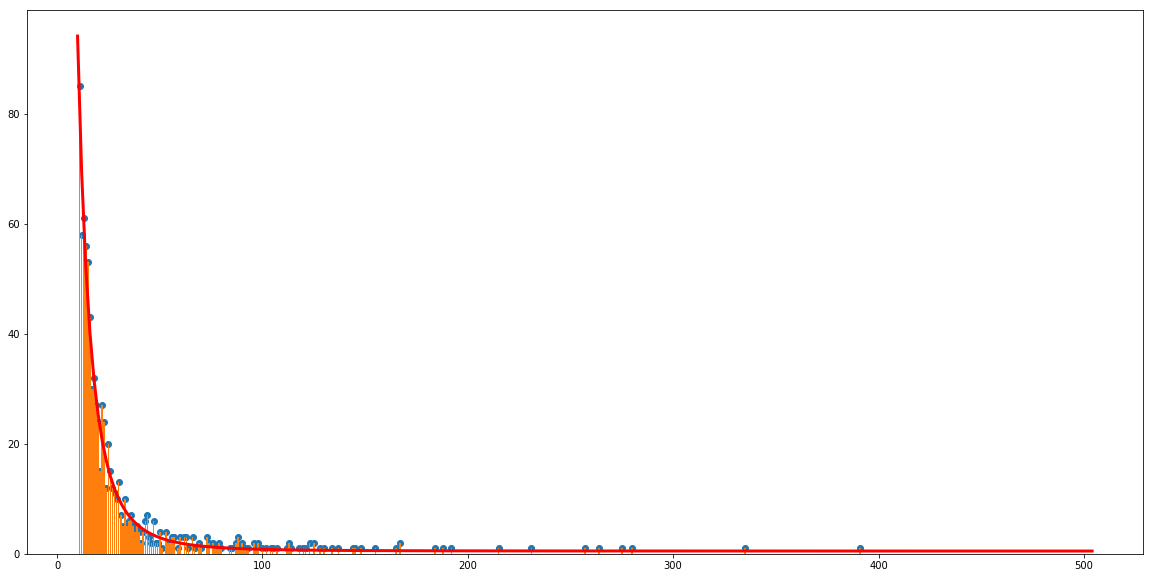

In [164]:
popt = Fof_approximation(arr)

In [165]:
def GoodTuring(frequency, N, popt):
    try:
        n = N[frequency]
    except KeyError:
        n = f(frequency, *popt)
    try:
        m = N[frequency+1]
    except KeyError:
        m = f(frequency+1, *popt)
    c = (frequency+1)*(m/n)
    return c

In [166]:
print (GoodTuring(10, N, popt))

8.657407407407408


In [167]:
d = []
for i in range(1,11):
    d.append(i-GoodTuring(i, N, popt))

In [168]:
print (np.mean(d))

1.0503351288333451


In [176]:
def Perplexity(sentence, mode):
    sentence = text.split()
    p = 0
    if (mode == 1):
        for i in range(len(sentence)-1):
            p += math.log((GoodTuring(bigrams.get(' '.join(sentence[i:i+2]), 0), N, popt))/float(unigrams[sentence[i]]))
    
    else:
        for i in range(len(sentence)-1):
            p += math.log(add1_smoothed_count(' '.join(sentence[i:i+2]))/float(unigrams[sentence[i]]))
        
    return math.exp((-1*p)/(len(sentence)-2))

In [177]:
print (Perplexity('<s> it is my strong impression that i left this door shut just now </s>', 1))

14.246927360213437


In [172]:
GT = []
A1S = []
for i in test:
    try:
        GT.append(Perplexity(i, 1))
        A1S.append(Perplexity(i, 0))
    except:
        continue